#### Import / Global Vars

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#imports section
import pandas_datareader.data as web
import numpy as np
import pandas as pd
import cvxpy as cvx
import re, os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from math import *
from datetime import datetime, date, time, timedelta
from time import sleep
from mvo_utils_v2 import *
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
# Global variables
log = True
refresh_pricing = False
universe = 'spy-sectors' # 'spy_sectors OR 'ark_etfs'
active_etf = None # ETF name OR None for broad market
#variables for performance analysis
lb = 60; min_gross=1; max_gross=1; min_w=0.0; max_w=0.05 # default optimization vars

#### Load sector components from hard-drive

In [4]:
# load spy sector components
# would be nice to load a JSON with configuration
ticker_map = {
    'benchmark': ['SPY'],
    'equity': ['VTI','VTV','VOE','VBR','VEA','VWO'],
    'fixed_income': ['VTIP', 'SHV', 'MUB', 'LQD', 'BNDX', 'EMB'],
    'spy-sectors': ['XLE', 'XLU', 'XLK', 'XLB', 'XLP', 'XLY', 'XLI', 'XLV', 'XLF', 'XLRE'],
    'ark-etfs': ['ARKG', 'ARKK', 'ARKQ', 'ARKW']
}

config = {
    'spy-sectors' : {
        'hold_cols': ['Symbol','Company Name', 'Index Weight'],
        'hold_format': r'holdings-spy-',
        'idx_col': 'Symbol',
        'fname': 'spy-sectors',
        'skiprows': 1
    },
    'ark-etfs' : {
        'hold_cols': ['ticker','company', 'weight(%)'],
        'hold_format': r'holdings-ark-',
        'idx_col': 'ticker',
        'fname': 'ark-etfs',
        'skiprows': 0
    }
}

hold_cols = config[universe]['hold_cols']
hold_format = config[universe]['hold_format']
idx_col = config[universe]['idx_col']
fname = config[universe]['fname']
skiprows = config[universe]['skiprows']

companies = load_components(
    companies, hold_format, hold_cols, 
    idx_col, ticker_map[universe], srows=skiprows)
print("Companies loaded:", companies.shape)
px_etfs = load_pricing(fname + '.csv', 'Date')
px_spy = load_pricing('SPY.csv', 'Date')

Companies loaded: (505, 3)
Loaded pricing for spy-sectors.csv, with shape (69, 10)
Loaded pricing for SPY.csv, with shape (69, 1)


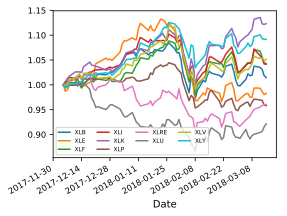

In [5]:
ax = compound(px_etfs).plot(fontsize='small', figsize=(4,3)) # exclude from long strat the negative sectors?
ax.legend(fontsize='xx-small', ncol=4)

#### Get Data from the Server

In [6]:
# New approach using dynamic key lookup name
if refresh_pricing:
    etfs = [e for e in ticker_map[universe]]
    refresh_components(etfs)
    get_safe_pricing(universe + '.csv', ticker_map[universe], start_date)
    get_safe_pricing('SPY.csv', ['SPY'], start_date)
    px_etfs = load_pricing(universe + '.csv', 'Date')
    px_spy = load_pricing('SPY.csv', 'Date')

In [7]:
# Load pricing for components of each sectors
consol_px = clean_nas(load_consol_px(ticker_map, universe))
if(active_etf != None): companies = companies[companies['ETF']==active_etf] # filter by selected ETF
tickers = companies.index.tolist()
tickers=[i for i in tickers if i not in ['BF.b','BRK.b']] ## esta es una correcion extra para no incluir 'BF.b','BRK.b'
consol_px = consol_px[list(set(tickers))]

Loaded pricing for XLE-hold-pricing.csv, with shape (69, 32)
Loaded pricing for XLU-hold-pricing.csv, with shape (69, 28)
Loaded pricing for XLK-hold-pricing.csv, with shape (69, 71)
Loaded pricing for XLB-hold-pricing.csv, with shape (69, 25)
Loaded pricing for XLP-hold-pricing.csv, with shape (69, 34)
Loaded pricing for XLY-hold-pricing.csv, with shape (69, 84)
Loaded pricing for XLI-hold-pricing.csv, with shape (69, 70)
Loaded pricing for XLV-hold-pricing.csv, with shape (69, 61)
Loaded pricing for XLF-hold-pricing.csv, with shape (69, 67)
Loaded pricing for XLRE-hold-pricing.csv, with shape (69, 33)


#### Generate Trading Recomendations

In [8]:
# Removing tickers for M&A targets and diff class shares of same co.
remove_tickers = ['CSRA', 'DPS', 'UAA', 'DISCK', 'JUNO', 'XL', 'WELL', 'BKNG', 'SNI','EVGN']
remove = list(set(remove_tickers).intersection(consol_px.columns.tolist()))
if len(remove) > 0:
    consol_px.drop(remove, axis=1, inplace=True)
consol_px.shape
consol_px = consol_px[sorted(consol_px.columns.tolist())]
consol_px.to_csv("consol_algo.csv")
consol_px[consol_px.columns[:10]].tail(3)

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI
Date,,,,,,,,,,
2018-03-13,70.680000,56.230000,119.000000,179.970001,119.750000,100.599998,63.200001,162.490005,219.759995,94.660004
2018-03-14,69.919998,55.279999,117.059998,178.440002,118.940002,98.580002,62.860001,161.000000,218.440002,94.089996
2018-03-15,70.230003,55.000000,117.050003,179.330002,116.221001,97.557503,62.785000,161.990005,219.210007,93.820000


In [9]:
# range of potential gammas using logspace
as_of = consol_px.index.to_datetime()[-1:] # date as of when we want the weights vector
SAMPLES = 100; gamma_vals = np.logspace(-2, 3, num=SAMPLES)
%time gamma_val, gamma_sr = quick_gamma(gamma_vals, consol_px, hist_window, lb, as_of, min_gross, max_gross, min_w, max_w)
print("Gamma: {0:.2f}, SR Ratio {1:.2f}, Lookback: {2}, Max Weight: {3}".format(gamma_val, gamma_sr, lb, max_w))

CPU times: user 4.28 s, sys: 310 ms, total: 4.59 s
Wall time: 6.83 s
Gamma: 0.03, SR Ratio 2.79, Lookback: 60, Max Weight: 0.05


In [10]:
# LONG-ONLY # portfolio optimization
px_portion, returns, alloc, pdf = recommend_allocs(
    consol_px, hist_window, lb, as_of, min_gross, max_gross, min_w, max_w, gamma_val)
rec = last_allocation(alloc, 0.01)
rec.T

,ABBV,ADBE,ADSK,AKAM,AMZN,APC,EW,GWW,HPE,IDXX,KSS,LRCX,MU,NFLX,NVDA,STX,TPR,TRIP,VRTX,WDC
Allocation,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05


In [56]:
# LONG-SHORT # portfolio optimization

def ls_recommend_allocs(px, lb, as_of, min_sum, max_sum, min_w, max_w, gamma):
    px = clean_nas(px) # clean dataframe
    px_portion = px[-lb:].copy() # subselect the period to optimize; frame and lb were duplicatives
    returns, alloc = ls_get_weights(
        px_portion, as_of, lb, min_sum, max_sum, min_w, max_w, gamma) # subselect the period to optimize

    # 3- modify calc_performance to take into account negative weights
    port_perf = calc_port_performance(returns.values, alloc.values)
    pdf = pd.DataFrame(port_perf, index=returns.index, columns=["Quantum"])
    return px_portion, returns, alloc, pdf

# 1- decompose the recommend_allocs
def ls_get_weights(px, as_of, lb, min_sum, max_sum, min_w, max_w, gamma):
    lb_rets = px.sort_index().pct_change().dropna() # capture the last lb days going back
    n = lb_rets.shape[1]; mu = lb_rets.mean().values.T; Sigma = lb_rets.cov().values
    w = cvx.Variable(n)
    
    gamma = cvx.Parameter(sign='positive')
    Lmax = cvx.Parameter()
    ret = mu.T * w; risk = cvx.quad_form(w, Sigma)

    # 2- change problem and constraints
    lo_obj = cvx.Maximize(ret - gamma*risk)
    #ls_obj = cvx.Maximize(ret)
    
    lo_const = [cvx.sum_entries(w) >= min_sum, cvx.sum_entries(w) <= max_sum, w > min_w, w < max_w]
    ls_const = [cvx.sum_entries(w) >= 0.7, cvx.norm(w, 1) < Lmax, w <= 0.05, w >= -0.05]

    #ls_bound_risk = [cvx.sum_entries(w) == 1, cvx.norm(w, 1) < Lmax, risk <= 0.1, w > -0.05, w < 0.05]
    #ls_const2 = [cvx.sum_entries(w) == 1, cvx.norm(w, 1) < Lmax, w > -0.05, w < 0.05]
    #ls_const3 = [cvx.norm(w) < 1, risk <= 0.1, w > -0.05, w < 0.05]

    prob = cvx.Problem(lo_obj, ls_const)
    gamma.value = gamma_val; Lmax.value = 1.3
    prob.solve()
    if prob.status == 'optimal': weights = w.value
    
    np_weights = np.array(weights)
    lb_weights = pd.DataFrame(np_weights.T, index=[as_of], columns=lb_rets.columns)
    
    return lb_rets, lb_weights

px_portion, returns, alloc, pdf = ls_recommend_allocs(
    consol_px, lb, as_of, min_gross, max_gross, min_w, max_w, gamma_val)
rec = last_allocation(alloc, -0.05)
#rec = rec.astype(np.float).applymap(short_float)
#rec.sort_values(by='Allocation').applymap(short_float)

long = rec[(rec>0.01).values]
short = rec[(rec<-0.01).values]
long.sum(), short.sum()
l_s = long.append(short)
portfolio_metrics('L/S', pdf)
#pdf.plot()
at = alloc[l_s.index.tolist()[:3]]

L/S Return: 0.35, StdDev: 0.09, Sharpe: 3.94


In [57]:
at.columns
rets = consol_px[-4:][at.columns].pct_change().dropna().values
rets

array([[ 0.01225695, -0.00534085, -0.01712795],
       [-0.00676408, -0.00600652,  0.00139707],
       [-0.02286027,  0.00352502,  0.00425877]])

In [58]:
np_wt = np.array([
    [0.05,0.05,0.05],
    [0.05,-0.05,-0.05],
    [-0.05,0.05,-0.05],
])
calc_port_performance(rets,np_wt)

array([0.99948941, 0.99938173, 1.00048737])

array([0.05, 0.9 ])

In [49]:
## tickers = rec.index.tolist()
recommend = rec.copy()
cos_no_dup = companies.drop_duplicates(subset='Company')
recommend['Sector'] = cos_no_dup.loc[tickers]['ETF']
recommend['Company'] = cos_no_dup.loc[tickers][['Company']]
recommend = recommend.astype({"Allocation": np.float})
recommend[['Company', 'Sector', 'Allocation']]
recommend

,Allocation,Sector,Company
A,1.793118e-14,XLV,Agilent Technologies Inc
AAL,1.691704e-14,XLI,American Airlines Group Inc.
AAP,1.873262e-14,XLY,Advance Auto Parts Inc
AAPL,1.868373e-14,XLK,Apple Inc.
ABBV,2.756792e-14,XLV,AbbVie Inc.
ABC,1.713195e-14,XLV,AmerisourceBergen Corp
ABT,1.696444e-14,XLV,Abbott Laboratories
ACN,1.715098e-14,XLK,Accenture plc A
ADBE,3.879876e-14,XLK,Adobe Systems Inc
ADI,1.699286e-14,XLK,Analog Devices Inc


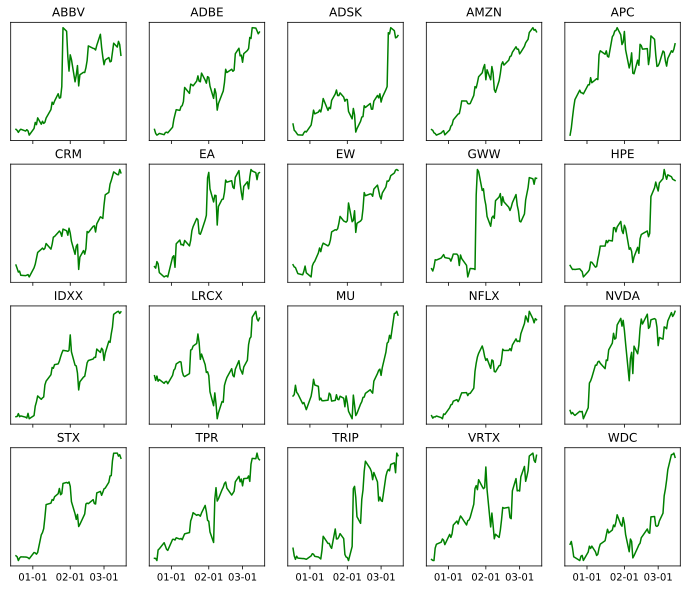

In [58]:
# plots all tickers to verify if there are any M&A targets
nbr_charts = len(sorted(tickers)); cols = 5
fig, ax = plt.subplots(nbr_charts // cols, cols, figsize=(12,10), sharex=True)
for i, axi in enumerate(ax.flat):
    co = tickers[i]; df_range = consol_px[co][-lb:]
    axi.plot(df_range.index.to_datetime().tolist(), df_range.values, '-g')
    axi.set(title=co)
    axi.yaxis.set_major_locator(plt.NullLocator())
    axi.xaxis.set_major_locator(mdates.MonthLocator())
    axi.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

In [13]:
sect_group_stats(recommend, 'Sector').sort_values(by='Sector Weight', ascending=False)

Total % Allocation 100.00


,Sector Weight,Avg Position
XLK,0.45,0.05
XLY,0.25,0.05
XLV,0.20,0.05
XLE,0.05,0.05
XLI,0.05,0.05


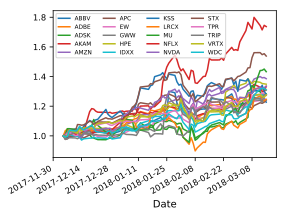

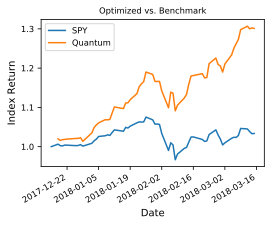

In [14]:
ax = compound(consol_px[recommend.index][-hist_window:]).plot(fontsize='small', figsize=(4,3))
ax.legend(fontsize='xx-small', ncol=4)
idx = px_spy.iloc[-(len(pdf.index)+1):].index
idx_px_spy = compound(px_spy.loc[idx])
plot_two_series(idx_px_spy, pdf, 'SPY', 'Quantum', 'Date', 'Index Return', 'Optimized vs. Benchmark')
# need to add 1 at the begining of pdf

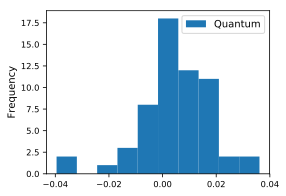

In [15]:
pdf.pct_change().plot(kind='hist', figsize=(4,3), fontsize='small')

In [16]:
# Outputs for trade execution
px = consol_px[recommend.index][-lb:]
date = px[-1:].index.to_datetime().strftime(date_fmt)[0]
ret, risk = port_metrics(px_portion, rec)

trading_cols = ['Company', 'Price', 'Allocation', 'Dollar Value', 'Shares']
trading_df = pd.DataFrame([], index=rec.index, columns=trading_cols)

round_shares = lambda x: round(x, 0)
port_bal = 231000; alloc = rec.T.values
pvalue = (port_bal * alloc)
shares = (port_bal * alloc) / px[-1:]
shares.apply(round_shares).T.sort_index()

trading_df['Company'] = recommend['Company']
trading_df['Price'] = px[-1:].T
trading_df['Allocation'] = recommend['Allocation']
trading_df['Dollar Value'] = trading_df['Allocation'] * port_bal
trading_df['Shares'] = trading_df['Dollar Value'] / trading_df['Price']

print("Time Window: {}, Lookback: {}, MinGross: {}, MaxGross: {}, MinWeight: {}, MaxWeight: {}".format(hist_window, lb, min_gross, max_gross, min_w, max_w))
print("Ann. Ret: {0:.2f}, Risk: {1:.2f} Sharpe: {2:.2f}".format(ret, risk, ret / risk))
print("Date: {0}, Total Invested: {1:.2f}, Total Allocation: {2:.2f}%".format(date, trading_df['Dollar Value'].sum(), trading_df['Allocation'].sum() * 100))
trading_df.head()
trading_df = trading_df.astype({'Dollar Value':np.int, 'Shares':np.int})
trading_df.sort_index()

Time Window: 100, Lookback: 60, MinGross: 1, MaxGross: 1, MinWeight: 0.0, MaxWeight: 0.05
Ann. Ret: 0.30, Risk: 0.11 Sharpe: 2.79
Date: 2018-03-15, Total Invested: 231000.00, Total Allocation: 100.00%


,Company,Price,Allocation,Dollar Value,Shares
ABBV,AbbVie Inc.,116.221001,0.05,11549,99
ADBE,Adobe Systems Inc,219.210007,0.05,11549,52
ADSK,Autodesk Inc,136.770004,0.05,11549,84
AKAM,Akamai Technologies Inc,75.309998,0.05,11549,153
AMZN,Amazon.com Inc,1581.880005,0.05,11549,7
APC,Anadarko Petroleum Corp,59.590000,0.05,11549,193
EW,Edwards Lifesciences Corp,140.759995,0.05,11549,82
GWW,Grainger W.W. Inc,280.015015,0.05,11549,41
HPE,Hewlett Packard Enterprise Co,18.815001,0.05,11549,613
IDXX,IDEXX Laboratories Inc,204.289993,0.05,11549,56
